# Множественная линейная регрессия: Зависимость численности населения от экономических и экологических факторов

## Модель 4
- **y** - численность населения (млн человек)
- **x1** - ВВП (млрд долларов США)
- **x2** - уровень выброса CO₂ (тонн на душу населения)
- **x3** - энергопотребление (кВт·ч на душу населения)
- **x4** - расходы на здравоохранение (% от ВВП)
- **x5** - уровень урбанизации (%)

## Цель исследования
Построить множественную линейную регрессионную модель для прогнозирования численности населения, оценить значимость коэффициентов регрессии и проверить адекватность модели.


In [181]:
# Импорт необходимых библиотек для регрессионного анализа

# pandas - для работы с табличными данными (DataFrame)
import pandas as pd

# numpy - для математических операций с массивами
import numpy as np

# matplotlib - базовая библиотека для создания графиков
import matplotlib.pyplot as plt

# seaborn - расширенная библиотека для статистической визуализации
import seaborn as sns

# scipy.stats - статистические функции и распределения
from scipy import stats
from scipy.stats import t, f, shapiro, normaltest

# sklearn - машинное обучение и метрики
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# statsmodels - продвинутая статистика и регрессионный анализ
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

# отключение предупреждений для чистоты вывода
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля и размеров графиков для лучшего отображения
plt.style.use('default')  # использование стандартного стиля matplotlib
sns.set_palette("husl")   # установка цветовой палитры для seaborn
plt.rcParams['figure.figsize'] = (12, 8)  # размер фигур по умолчанию
plt.rcParams['font.size'] = 12             # размер шрифта

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


In [182]:
# Загрузка данных
df = pd.read_csv('data.csv')

print("Размер выборки:", df.shape)
print("\nПервые 5 строк данных:")
print(df.head())

print("\nИнформация о данных:")
print(df.info())

print("\nПроверка на пропущенные значения:")
print(df.isnull().sum())


Размер выборки: (57, 7)

Первые 5 строк данных:
     Country  Population_millions  GDP_billion_USD  \
0    Belarus                  9.5             63.1   
1     Russia                144.1           1829.0   
2    Ukraine                 41.2            200.1   
3     Poland                 37.8            679.4   
4  Lithuania                  2.8             56.5   

   CO2_emissions_tons_per_capita  Energy_consumption_kWh_per_capita  \
0                            6.4                               3250   
1                           11.9                               6500   
2                            4.7                               2850   
3                            8.1                               4100   
4                            4.5                               3850   

   Healthcare_expenditure_percent_GDP  Urbanization_percent  
0                                 6.1                  79.5  
1                                 5.3                  74.8  
2             

In [183]:
# Переименование столбцов для удобства анализа
df_analysis = df.rename(columns={
    'Population_millions': 'y_Population',
    'GDP_billion_USD': 'x1_GDP',
    'CO2_emissions_tons_per_capita': 'x2_CO2',
    'Energy_consumption_kWh_per_capita': 'x3_Energy',
    'Healthcare_expenditure_percent_GDP': 'x4_Healthcare',
    'Urbanization_percent': 'x5_Urbanization'
})

# Выбор только числовых столбцов для анализа
numerical_cols = ['y_Population', 'x1_GDP', 'x2_CO2', 'x3_Energy', 'x4_Healthcare', 'x5_Urbanization']
df_numerical = df_analysis[numerical_cols].copy()

print("Описательная статистика:")
print(df_numerical.describe())


Описательная статистика:
       y_Population        x1_GDP     x2_CO2     x3_Energy  x4_Healthcare  \
count     57.000000     57.000000  57.000000     57.000000      57.000000   
mean      93.889474   1521.742105   5.908772   6398.245614       7.770175   
std      261.555343   3847.147093   3.316586   7609.474621       2.730448   
min        0.400000     24.200000   1.200000    750.000000       1.200000   
25%        6.900000    181.800000   3.800000   2850.000000       6.100000   
50%       19.100000    396.000000   5.000000   4650.000000       7.800000   
75%       67.400000   1293.000000   7.700000   7300.000000       9.700000   
max     1439.300000  23315.100000  15.600000  54000.000000      17.100000   

       x5_Urbanization  
count        57.000000  
mean         74.250877  
std          14.750449  
min          35.000000  
25%          64.200000  
50%          76.600000  
75%          85.500000  
max         100.000000  


## 1. Корреляционный анализ и отбор факторов

### 1.1 Анализ корреляций


Корреляционная матрица:
                 y_Population  x1_GDP  x2_CO2  x3_Energy  x4_Healthcare  \
y_Population            1.000   0.582  -0.041     -0.122         -0.195   
x1_GDP                  0.582   1.000   0.368      0.055          0.364   
x2_CO2                 -0.041   0.368   1.000      0.294          0.351   
x3_Energy              -0.122   0.055   0.294      1.000          0.298   
x4_Healthcare          -0.195   0.364   0.351      0.298          1.000   
x5_Urbanization        -0.339   0.019   0.312      0.369          0.425   

                 x5_Urbanization  
y_Population              -0.339  
x1_GDP                     0.019  
x2_CO2                     0.312  
x3_Energy                  0.369  
x4_Healthcare              0.425  
x5_Urbanization            1.000  


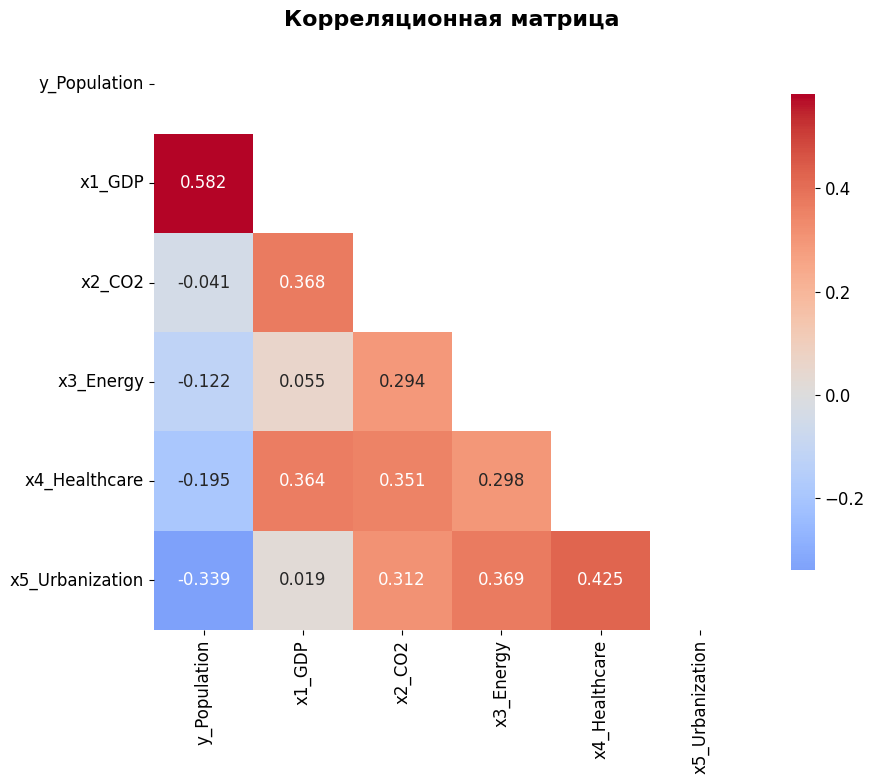

In [184]:
# Вычисление корреляционной матрицы
correlation_matrix = df_numerical.corr()

print("Корреляционная матрица:")
print(correlation_matrix.round(3))

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            mask=mask,
            cbar_kws={"shrink": .8},
            fmt='.3f')
plt.title('Корреляционная матрица', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### 1.2 Отбор значимых факторов


In [185]:
# Анализ корреляций с зависимой переменной y_Population
y_correlations = correlation_matrix['y_Population'].drop('y_Population')

print("Корреляции с численностью населения (y):")
print("="*50)
for var, corr in y_correlations.items():
    print(f"{var:<20}: {corr:>7.3f}")

# Определение факторов с корреляцией >= 0.3 по модулю (более низкий порог для регрессии)
threshold = 0.3
relevant_factors = []

print(f"\nАнализ факторов по критерию |r| >= {threshold}:")
print("="*45)
print(f"{'Фактор':<20} {'Корреляция':<12} {'Статус'}")
print("-"*45)

for var, corr in y_correlations.items():
    status = "ВКЛЮЧЕН" if abs(corr) >= threshold else "ИСКЛЮЧЕН"
    print(f"{var:<20} {corr:>8.3f}     {status}")
    if abs(corr) >= threshold:
        relevant_factors.append(var)

print(f"\nОтобранные факторы: {relevant_factors}")
print(f"Количество отобранных факторов: {len(relevant_factors)}")


Корреляции с численностью населения (y):
x1_GDP              :   0.582
x2_CO2              :  -0.041
x3_Energy           :  -0.122
x4_Healthcare       :  -0.195
x5_Urbanization     :  -0.339

Анализ факторов по критерию |r| >= 0.3:
Фактор               Корреляция   Статус
---------------------------------------------
x1_GDP                  0.582     ВКЛЮЧЕН
x2_CO2                 -0.041     ИСКЛЮЧЕН
x3_Energy              -0.122     ИСКЛЮЧЕН
x4_Healthcare          -0.195     ИСКЛЮЧЕН
x5_Urbanization        -0.339     ВКЛЮЧЕН

Отобранные факторы: ['x1_GDP', 'x5_Urbanization']
Количество отобранных факторов: 2


### 1.3 Проверка мультиколлинеарности (VIF)


In [186]:
# Расчет VIF для отобранных факторов
if len(relevant_factors) > 0:
    X_vif = df_numerical[relevant_factors]
    
    print("Проверка мультиколлинеарности (VIF - Variance Inflation Factor):")
    print("="*60)
    print("VIF < 5: мультиколлинеарность отсутствует")
    print("5 <= VIF < 10: умеренная мультиколлинеарность")
    print("VIF >= 10: высокая мультиколлинеарность (фактор следует исключить)")
    print("-"*60)
    
    vif_data = pd.DataFrame()
    vif_data["Фактор"] = relevant_factors
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(relevant_factors))]
    
    print(vif_data.to_string(index=False))
    
    # Фильтрация факторов с VIF < 10
    final_factors = vif_data[vif_data["VIF"] < 10]["Фактор"].tolist()
    
    if len(final_factors) < len(relevant_factors):
        print(f"\n⚠ Исключены факторы с высокой мультиколлинеарностью (VIF >= 10)")
        print(f"Итоговые факторы для модели: {final_factors}")
        relevant_factors = final_factors
    else:
        print("\n✓ Все факторы прошли проверку на мультиколлинеарность")
else:
    print("Не отобрано ни одного фактора для анализа VIF")


Проверка мультиколлинеарности (VIF - Variance Inflation Factor):
VIF < 5: мультиколлинеарность отсутствует
5 <= VIF < 10: умеренная мультиколлинеарность
VIF >= 10: высокая мультиколлинеарность (фактор следует исключить)
------------------------------------------------------------
         Фактор      VIF
         x1_GDP 1.155781
x5_Urbanization 1.155781

✓ Все факторы прошли проверку на мультиколлинеарность


## 2. Построение множественной линейной регрессии

### 2.1 Подготовка данных


In [187]:
# Подготовка данных для регрессии
y = df_numerical['y_Population'].values
X = df_numerical[relevant_factors].values
X_with_const = sm.add_constant(X)  # добавление константы (свободного члена)

print(f"Размерность матрицы факторов X: {X.shape}")
print(f"Размерность вектора y: {y.shape}")
print(f"\nФакторы в модели: {relevant_factors}")

# Названия для коэффициентов
feature_names = ['const'] + relevant_factors


Размерность матрицы факторов X: (57, 2)
Размерность вектора y: (57,)

Факторы в модели: ['x1_GDP', 'x5_Urbanization']


### 2.2 Оценка параметров модели (МНК - Метод Наименьших Квадратов)


In [188]:
# Построение модели с помощью statsmodels (для детальной статистики)
model = sm.OLS(y, X_with_const)
results = model.fit()

print("="*70)
print("РЕЗУЛЬТАТЫ МНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ")
print("="*70)
print(results.summary())

# Извлечение коэффициентов
coefficients = results.params
print("\n" + "="*70)
print("КОЭФФИЦИЕНТЫ РЕГРЕССИИ")
print("="*70)
for name, coef in zip(feature_names, coefficients):
    print(f"{name:<20}: {coef:>12.6f}")


РЕЗУЛЬТАТЫ МНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     23.19
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           5.38e-08
Time:                        14:59:39   Log-Likelihood:                -380.01
No. Observations:                  57   AIC:                             766.0
Df Residuals:                      54   BIC:                             772.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

### 2.3 Уравнение регрессии


In [189]:
# Формирование уравнения регрессии
equation = f"y = {coefficients[0]:.4f}"
for i, (factor, coef) in enumerate(zip(relevant_factors, coefficients[1:]), 1):
    sign = "+" if coef >= 0 else ""
    equation += f" {sign} {coef:.4f}*{factor}"

print("="*70)
print("УРАВНЕНИЕ МНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ")
print("="*70)
print(f"\n{equation}\n")
print("="*70)


УРАВНЕНИЕ МНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ

y = 494.5411 + 0.0401*x1_GDP  -6.2168*x5_Urbanization



## 3. Оценка значимости коэффициентов регрессии

### 3.1 t-критерий Стьюдента для коэффициентов


In [190]:
# Анализ значимости коэффициентов
n = len(y)  # количество наблюдений
k = len(relevant_factors)  # количество факторов (без константы)
df_residual = n - k - 1  # степени свободы

alpha = 0.05  # уровень значимости
t_critical = t.ppf(1 - alpha/2, df_residual)  # критическое значение t-статистики

print("="*80)
print("ПРОВЕРКА ЗНАЧИМОСТИ КОЭФФИЦИЕНТОВ (t-критерий Стьюдента)")
print("="*80)
print(f"Уровень значимости α = {alpha}")
print(f"Степени свободы = {df_residual}")
print(f"Критическое значение t-критерия = ±{t_critical:.4f}")
print("-"*80)
print(f"{'Параметр':<20} {'Коэффициент':<15} {'t-статистика':<15} {'p-value':<12} {'Значимость'}")
print("-"*80)

for name, coef, t_stat, p_val in zip(feature_names, results.params, results.tvalues, results.pvalues):
    significance = "ДА" if p_val < alpha else "НЕТ"
    print(f"{name:<20} {coef:>14.6f} {t_stat:>14.4f} {p_val:>11.4f}  {significance}")

print("="*80)
print("\nИнтерпретация:")
print("- Если p-value < 0.05, коэффициент статистически значим")
print("- Если |t-stat| > t_critical, коэффициент статистически значим")


ПРОВЕРКА ЗНАЧИМОСТИ КОЭФФИЦИЕНТОВ (t-критерий Стьюдента)
Уровень значимости α = 0.05
Степени свободы = 54
Критическое значение t-критерия = ±2.0049
--------------------------------------------------------------------------------
Параметр             Коэффициент     t-статистика    p-value      Значимость
--------------------------------------------------------------------------------
const                    494.541119         3.6860      0.0005  ДА
x1_GDP                     0.040053         5.9012      0.0000  ДА
x5_Urbanization           -6.216790        -3.5118      0.0009  ДА

Интерпретация:
- Если p-value < 0.05, коэффициент статистически значим
- Если |t-stat| > t_critical, коэффициент статистически значим


### 3.2 Доверительные интервалы для коэффициентов


In [191]:
# Доверительные интервалы для коэффициентов
conf_int = results.conf_int(alpha=alpha)

print("="*70)
print(f"ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ ДЛЯ КОЭФФИЦИЕНТОВ (уровень доверия {(1-alpha)*100}%)")
print("="*70)
print(f"{'Параметр':<20} {'Нижняя граница':<20} {'Верхняя граница'}")
print("-"*70)

for name, (lower, upper) in zip(feature_names, conf_int):
    print(f"{name:<20} {lower:>19.6f} {upper:>19.6f}")

print("="*70)


ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ ДЛЯ КОЭФФИЦИЕНТОВ (уровень доверия 95.0%)
Параметр             Нижняя граница       Верхняя граница
----------------------------------------------------------------------
const                         225.552697          763.529541
x1_GDP                          0.026445            0.053661
x5_Urbanization                -9.765907           -2.667672


## 4. Оценка качества модели

### 4.1 Коэффициенты детерминации


In [192]:
# Метрики качества модели
y_pred = results.fittedvalues
r2 = results.rsquared
r2_adj = results.rsquared_adj
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / y)) * 100

print("="*70)
print("ПОКАЗАТЕЛИ КАЧЕСТВА МОДЕЛИ")
print("="*70)
print(f"R² (коэффициент детерминации):           {r2:.6f}")
print(f"R²_adj (скорректированный R²):           {r2_adj:.6f}")
print(f"RMSE (среднеквадратичная ошибка):        {rmse:.6f}")
print(f"MAE (средняя абсолютная ошибка):         {mae:.6f}")
print(f"MAPE (средняя абсолютная % ошибка):      {mape:.2f}%")
print("="*70)

print("\nИнтерпретация R²:")
if r2 >= 0.8:
    print(f"✓ R² = {r2:.4f} - модель объясняет {r2*100:.2f}% вариации (ОТЛИЧНОЕ качество)")
elif r2 >= 0.6:
    print(f"✓ R² = {r2:.4f} - модель объясняет {r2*100:.2f}% вариации (ХОРОШЕЕ качество)")
elif r2 >= 0.4:
    print(f"⚠ R² = {r2:.4f} - модель объясняет {r2*100:.2f}% вариации (УДОВЛЕТВОРИТЕЛЬНОЕ качество)")
else:
    print(f"✗ R² = {r2:.4f} - модель объясняет {r2*100:.2f}% вариации (НИЗКОЕ качество)")


ПОКАЗАТЕЛИ КАЧЕСТВА МОДЕЛИ
R² (коэффициент детерминации):           0.462004
R²_adj (скорректированный R²):           0.442078
RMSE (среднеквадратичная ошибка):        190.155819
MAE (средняя абсолютная ошибка):         104.114421
MAPE (средняя абсолютная % ошибка):      1199.40%

Интерпретация R²:
⚠ R² = 0.4620 - модель объясняет 46.20% вариации (УДОВЛЕТВОРИТЕЛЬНОЕ качество)


### 4.2 F-критерий Фишера (общая значимость модели)


In [193]:
# F-критерий для проверки общей значимости модели
f_statistic = results.fvalue
f_pvalue = results.f_pvalue
f_critical = f.ppf(1 - alpha, k, df_residual)

print("="*70)
print("ПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ (F-критерий Фишера)")
print("="*70)
print(f"Уровень значимости α = {alpha}")
print(f"Степени свободы числителя (k) = {k}")
print(f"Степени свободы знаменателя (n-k-1) = {df_residual}")
print(f"\nF-статистика (наблюдаемая):  {f_statistic:.6f}")
print(f"F-критическое:                {f_critical:.6f}")
print(f"p-value:                      {f_pvalue:.10f}")
print("-"*70)

if f_pvalue < alpha:
    print(f"\n✓ ВЫВОД: p-value ({f_pvalue:.10f}) < α ({alpha})")
    print("✓ Модель АДЕКВАТНА и статистически значима")
    print("✓ Регрессионное уравнение значимо отличается от простого среднего")
else:
    print(f"\n✗ ВЫВОД: p-value ({f_pvalue:.10f}) >= α ({alpha})")
    print("✗ Модель НЕ является статистически значимой")
    
if f_statistic > f_critical:
    print(f"✓ F-статистика ({f_statistic:.4f}) > F-критического ({f_critical:.4f})")
    print("✓ Дополнительное подтверждение значимости модели")
    
print("="*70)


ПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ (F-критерий Фишера)
Уровень значимости α = 0.05
Степени свободы числителя (k) = 2
Степени свободы знаменателя (n-k-1) = 54

F-статистика (наблюдаемая):  23.186267
F-критическое:                3.168246
p-value:                      0.0000000538
----------------------------------------------------------------------

✓ ВЫВОД: p-value (0.0000000538) < α (0.05)
✓ Модель АДЕКВАТНА и статистически значима
✓ Регрессионное уравнение значимо отличается от простого среднего
✓ F-статистика (23.1863) > F-критического (3.1682)
✓ Дополнительное подтверждение значимости модели


## 5. Анализ остатков (проверка предпосылок МНК)

### 5.1 Расчет остатков


In [194]:
# Расчет остатков
residuals = results.resid
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

print("="*70)
print("СТАТИСТИКА ОСТАТКОВ")
print("="*70)
print(f"Среднее значение остатков:     {residuals.mean():.6f}")
print(f"Ст. отклонение остатков:       {residuals.std():.6f}")
print(f"Минимальный остаток:           {residuals.min():.6f}")
print(f"Максимальный остаток:          {residuals.max():.6f}")
print("="*70)


СТАТИСТИКА ОСТАТКОВ
Среднее значение остатков:     -0.000000
Ст. отклонение остатков:       190.155819
Минимальный остаток:           -582.353874
Максимальный остаток:          975.942116


### 5.2 Проверка нормальности остатков


In [195]:
# Тесты на нормальность остатков
shapiro_stat, shapiro_p = shapiro(residuals)
jb_stat, jb_p, skew, kurtosis = jarque_bera(residuals)

print("="*70)
print("ПРОВЕРКА НОРМАЛЬНОСТИ ОСТАТКОВ")
print("="*70)
print(f"Тест Шапиро-Уилка:")
print(f"  Статистика: {shapiro_stat:.6f}")
print(f"  p-value:    {shapiro_p:.6f}")

if shapiro_p > alpha:
    print(f"  ✓ p-value > {alpha}: остатки распределены нормально")
else:
    print(f"  ⚠ p-value < {alpha}: есть отклонения от нормальности")

print(f"\nТест Харке-Бера:")
print(f"  Статистика: {jb_stat:.6f}")
print(f"  p-value:    {jb_p:.6f}")

if jb_p > alpha:
    print(f"  ✓ p-value > {alpha}: остатки распределены нормально")
else:
    print(f"  ⚠ p-value < {alpha}: есть отклонения от нормальности")
    
print("="*70)


ПРОВЕРКА НОРМАЛЬНОСТИ ОСТАТКОВ
Тест Шапиро-Уилка:
  Статистика: 0.692700
  p-value:    0.000000
  ⚠ p-value < 0.05: есть отклонения от нормальности

Тест Харке-Бера:
  Статистика: 440.853890
  p-value:    0.000000
  ⚠ p-value < 0.05: есть отклонения от нормальности


### 5.3 Проверка автокорреляции остатков (тест Дарбина-Уотсона)


In [196]:
# Тест Дарбина-Уотсона
dw_stat = durbin_watson(residuals)

print("="*70)
print("ПРОВЕРКА АВТОКОРРЕЛЯЦИИ ОСТАТКОВ (тест Дарбина-Уотсона)")
print("="*70)
print(f"Статистика Дарбина-Уотсона: {dw_stat:.6f}")
print("\nИнтерпретация:")
print("  DW ≈ 2:     автокорреляция отсутствует")
print("  DW < 1.5:   положительная автокорреляция")
print("  DW > 2.5:   отрицательная автокорреляция")
print("-"*70)

if 1.5 <= dw_stat <= 2.5:
    print(f"✓ DW = {dw_stat:.4f} - автокорреляция отсутствует")
elif dw_stat < 1.5:
    print(f"⚠ DW = {dw_stat:.4f} - обнаружена положительная автокорреляция")
else:
    print(f"⚠ DW = {dw_stat:.4f} - обнаружена отрицательная автокорреляция")
    
print("="*70)


ПРОВЕРКА АВТОКОРРЕЛЯЦИИ ОСТАТКОВ (тест Дарбина-Уотсона)
Статистика Дарбина-Уотсона: 1.256659

Интерпретация:
  DW ≈ 2:     автокорреляция отсутствует
  DW < 1.5:   положительная автокорреляция
  DW > 2.5:   отрицательная автокорреляция
----------------------------------------------------------------------
⚠ DW = 1.2567 - обнаружена положительная автокорреляция


### 5.4 Визуализация остатков


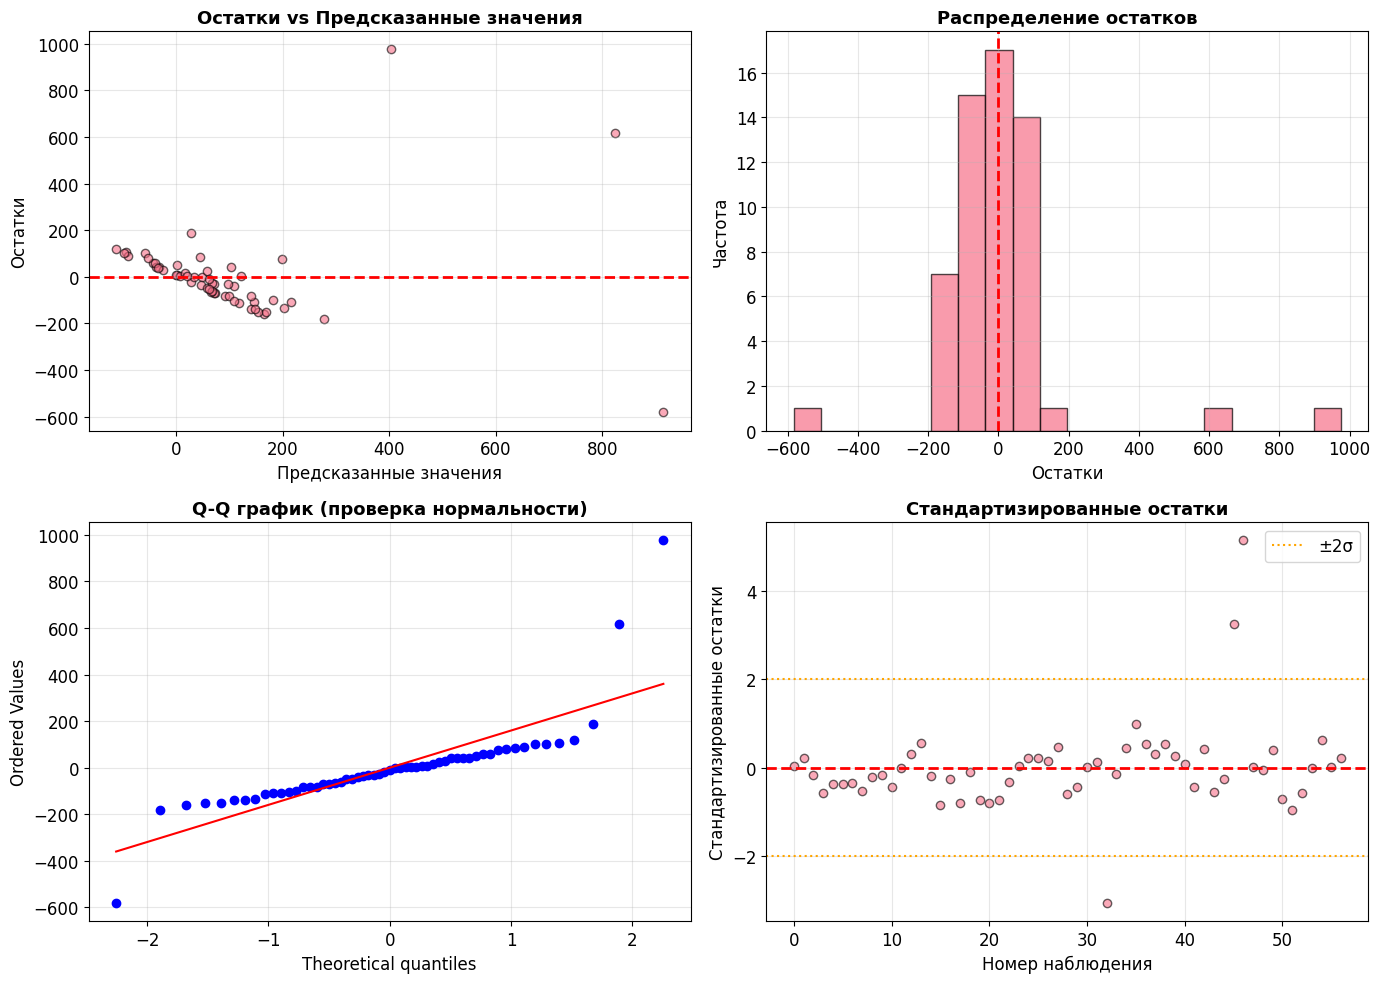

In [197]:
# Визуализация остатков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. График остатков vs предсказанные значения
axes[0, 0].scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Предсказанные значения', fontsize=12)
axes[0, 0].set_ylabel('Остатки', fontsize=12)
axes[0, 0].set_title('Остатки vs Предсказанные значения', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограмма остатков
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Остатки', fontsize=12)
axes[0, 1].set_ylabel('Частота', fontsize=12)
axes[0, 1].set_title('Распределение остатков', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot (проверка нормальности)
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q график (проверка нормальности)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Стандартизированные остатки
axes[1, 1].scatter(range(len(standardized_residuals)), standardized_residuals, alpha=0.6, edgecolors='k')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=2, color='orange', linestyle=':', linewidth=1.5, label='±2σ')
axes[1, 1].axhline(y=-2, color='orange', linestyle=':', linewidth=1.5)
axes[1, 1].set_xlabel('Номер наблюдения', fontsize=12)
axes[1, 1].set_ylabel('Стандартизированные остатки', fontsize=12)
axes[1, 1].set_title('Стандартизированные остатки', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Визуализация результатов

### 6.1 Фактические vs Предсказанные значения


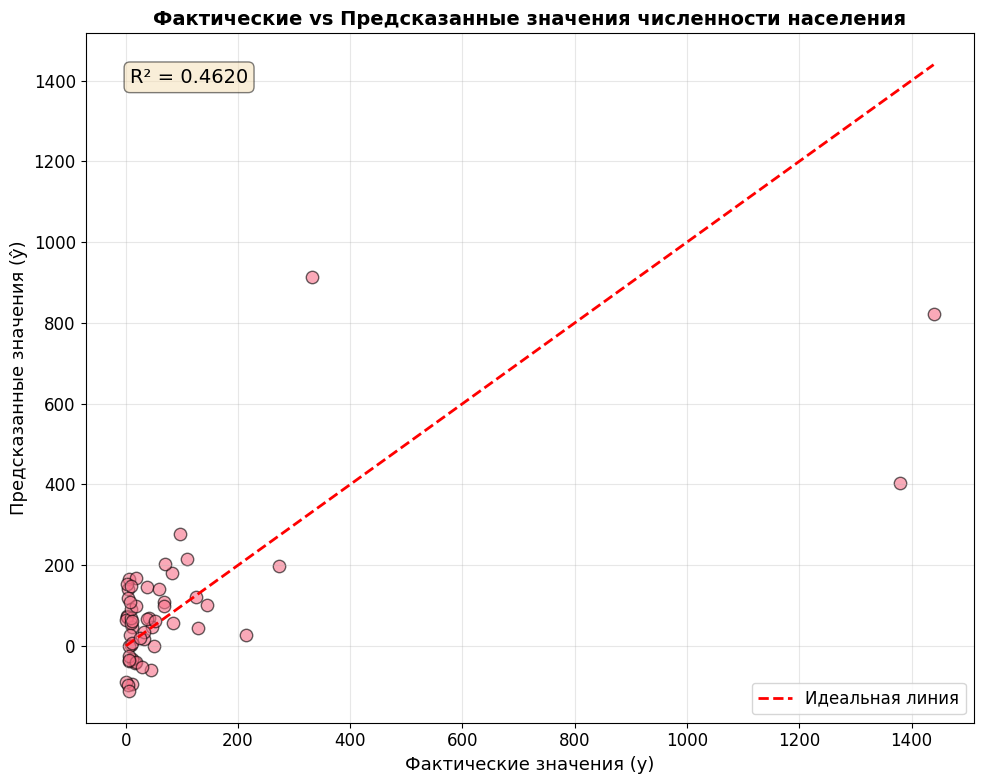

In [198]:
# График фактических vs предсказанных значений
plt.figure(figsize=(10, 8))
plt.scatter(y, y_pred, alpha=0.6, s=80, edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Идеальная линия')
plt.xlabel('Фактические значения (y)', fontsize=13)
plt.ylabel('Предсказанные значения (ŷ)', fontsize=13)
plt.title('Фактические vs Предсказанные значения численности населения', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Добавление R²
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=plt.gca().transAxes, 
         fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


### 6.2 Визуализация коэффициентов


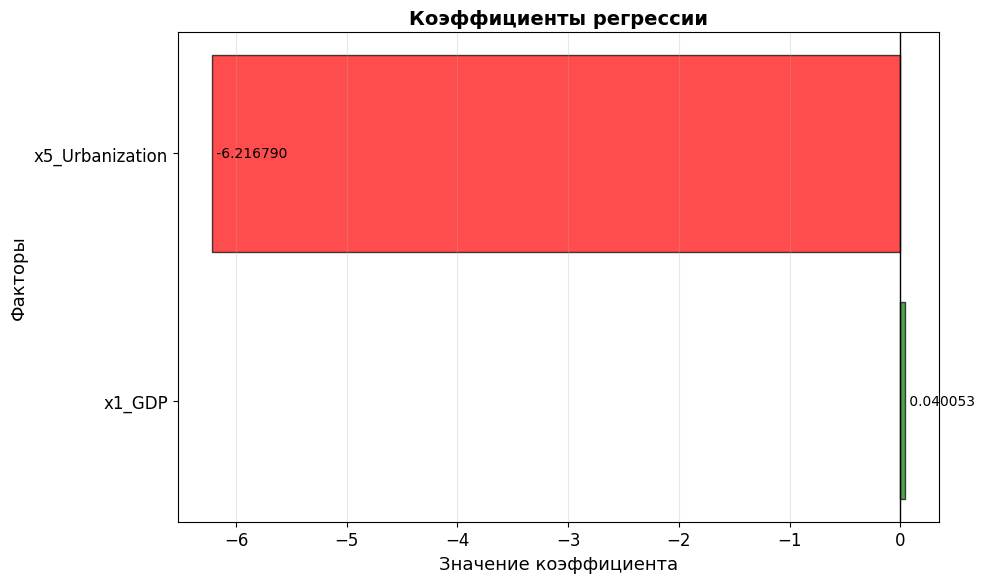

In [199]:
# Визуализация коэффициентов (исключая константу)
if len(relevant_factors) > 0:
    coefs = coefficients[1:]  # исключаем константу
    factors = relevant_factors
    
    plt.figure(figsize=(10, 6))
    colors = ['green' if c > 0 else 'red' for c in coefs]
    bars = plt.barh(factors, coefs, color=colors, alpha=0.7, edgecolor='black')
    plt.xlabel('Значение коэффициента', fontsize=13)
    plt.ylabel('Факторы', fontsize=13)
    plt.title('Коэффициенты регрессии', fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
    plt.grid(True, alpha=0.3, axis='x')
    
    # Добавление значений на график
    for i, (factor, coef) in enumerate(zip(factors, coefs)):
        plt.text(coef, i, f' {coef:.6f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


### 6.3 Графики зависимости y от каждого фактора


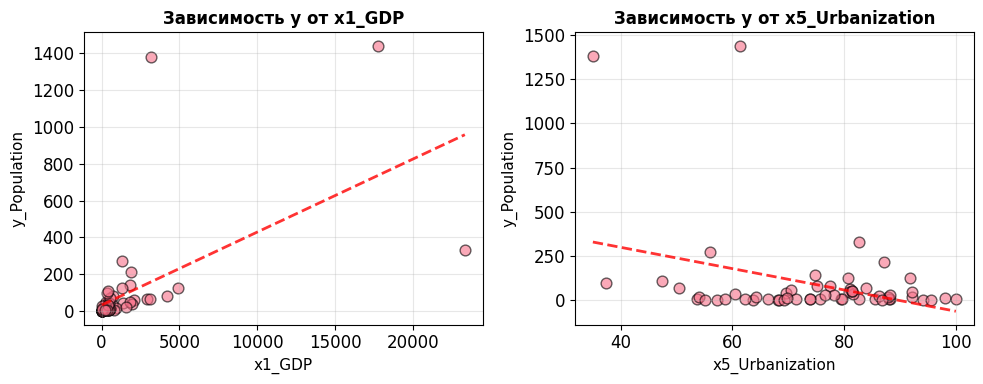

In [200]:
# Графики зависимости y от каждого фактора
if len(relevant_factors) > 0:
    n_factors = len(relevant_factors)
    n_cols = min(3, n_factors)
    n_rows = (n_factors + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    if n_factors == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, factor in enumerate(relevant_factors):
        x_vals = df_numerical[factor].values
        axes[idx].scatter(x_vals, y, alpha=0.6, s=60, edgecolors='k')
        
        # Добавление линии регрессии для одного фактора
        z = np.polyfit(x_vals, y, 1)
        p = np.poly1d(z)
        x_sorted = np.sort(x_vals)
        axes[idx].plot(x_sorted, p(x_sorted), "r--", alpha=0.8, linewidth=2)
        
        axes[idx].set_xlabel(factor, fontsize=11)
        axes[idx].set_ylabel('y_Population', fontsize=11)
        axes[idx].set_title(f'Зависимость y от {factor}', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    # Скрыть неиспользуемые subplot'ы
    for idx in range(n_factors, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


## 7. Итоговая таблица результатов


In [201]:
# Сводная таблица результатов
summary_df = pd.DataFrame({
    'Параметр': feature_names,
    'Коэффициент': results.params,
    'Ст. ошибка': results.bse,
    't-статистика': results.tvalues,
    'p-value': results.pvalues,
    'Значимость (α=0.05)': ['ДА' if p < 0.05 else 'НЕТ' for p in results.pvalues]
})

# Добавление доверительных интервалов
conf_int = results.conf_int(alpha=0.05)
summary_df['Нижняя граница (95%)'] = conf_int[:, 0]
summary_df['Верхняя граница (95%)'] = conf_int[:, 1]

print("="*120)
print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИОННОГО АНАЛИЗА")
print("="*120)
print(summary_df.to_string(index=False))
print("="*120)

# Итоговые метрики
print("\nИТОГОВЫЕ МЕТРИКИ МОДЕЛИ:")
print("-"*60)
print(f"Количество наблюдений (n):                {n}")
print(f"Количество факторов (k):                  {k}")
print(f"Коэффициент детерминации (R²):            {r2:.6f}")
print(f"Скорректированный R²:                     {r2_adj:.6f}")
print(f"F-статистика:                             {f_statistic:.6f}")
print(f"p-value (F-test):                         {f_pvalue:.10f}")
print(f"Модель значима:                           {'ДА' if f_pvalue < 0.05 else 'НЕТ'}")
print(f"Статистика Дарбина-Уотсона:               {dw_stat:.6f}")
print(f"RMSE:                                     {rmse:.6f}")
print(f"MAE:                                      {mae:.6f}")
print(f"MAPE:                                     {mape:.2f}%")
print("="*60)


ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИОННОГО АНАЛИЗА
       Параметр  Коэффициент  Ст. ошибка  t-статистика      p-value Значимость (α=0.05)  Нижняя граница (95%)  Верхняя граница (95%)
          const   494.541119  134.166892      3.686015 5.293069e-04                  ДА            225.552697             763.529541
         x1_GDP     0.040053    0.006787      5.901158 2.455293e-07                  ДА              0.026445               0.053661
x5_Urbanization    -6.216790    1.770240     -3.511835 9.075062e-04                  ДА             -9.765907              -2.667672

ИТОГОВЫЕ МЕТРИКИ МОДЕЛИ:
------------------------------------------------------------
Количество наблюдений (n):                57
Количество факторов (k):                  2
Коэффициент детерминации (R²):            0.462004
Скорректированный R²:                     0.442078
F-статистика:                             23.186267
p-value (F-test):                         0.0000000538
Модель значима:                

## 8. Выводы и интерпретация

### 8.1 Уравнение регрессии


In [202]:
print("="*80)
print("ВЫВОДЫ ПО РЕЗУЛЬТАТАМ МНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ")
print("="*80)
print("\n1. УРАВНЕНИЕ РЕГРЕССИИ:")
print("-"*80)
print(f"   {equation}")
print("-"*80)


ВЫВОДЫ ПО РЕЗУЛЬТАТАМ МНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ

1. УРАВНЕНИЕ РЕГРЕССИИ:
--------------------------------------------------------------------------------
   y = 494.5411 + 0.0401*x1_GDP  -6.2168*x5_Urbanization
--------------------------------------------------------------------------------


### 8.2 Значимость коэффициентов


In [203]:
print("\n2. ЗНАЧИМОСТЬ КОЭФФИЦИЕНТОВ:")
print("-"*80)
significant_count = sum(results.pvalues < 0.05)
print(f"   Всего параметров: {len(feature_names)}")
print(f"   Статистически значимых (p < 0.05): {significant_count}")
print("\n   Значимые коэффициенты:")
for name, p_val, coef in zip(feature_names, results.pvalues, results.params):
    if p_val < 0.05:
        print(f"     - {name}: коэффициент = {coef:.6f}, p-value = {p_val:.6f}")
        
print("\n   Незначимые коэффициенты:")
non_sig = False
for name, p_val, coef in zip(feature_names, results.pvalues, results.params):
    if p_val >= 0.05:
        print(f"     - {name}: коэффициент = {coef:.6f}, p-value = {p_val:.6f}")
        non_sig = True
if not non_sig:
    print("     Все коэффициенты статистически значимы")
print("-"*80)



2. ЗНАЧИМОСТЬ КОЭФФИЦИЕНТОВ:
--------------------------------------------------------------------------------
   Всего параметров: 3
   Статистически значимых (p < 0.05): 3

   Значимые коэффициенты:
     - const: коэффициент = 494.541119, p-value = 0.000529
     - x1_GDP: коэффициент = 0.040053, p-value = 0.000000
     - x5_Urbanization: коэффициент = -6.216790, p-value = 0.000908

   Незначимые коэффициенты:
     Все коэффициенты статистически значимы
--------------------------------------------------------------------------------


### 8.3 Качество модели


In [204]:
print("\n3. КАЧЕСТВО И АДЕКВАТНОСТЬ МОДЕЛИ:")
print("-"*80)
print(f"   R² = {r2:.6f} - модель объясняет {r2*100:.2f}% вариации")
print(f"   R²_adj = {r2_adj:.6f} - скорректированный показатель")
print(f"\n   F-статистика = {f_statistic:.6f}, p-value = {f_pvalue:.10f}")
if f_pvalue < 0.05:
    print("   ✓ Модель статистически значима (p-value < 0.05)")
    print("   ✓ Регрессионная модель превосходит тривиальную модель (среднее)")
else:
    print("   ✗ Модель не является статистически значимой (p-value >= 0.05)")

print(f"\n   RMSE = {rmse:.6f} (среднеквадратичная ошибка)")
print(f"   MAE = {mae:.6f} (средняя абсолютная ошибка)")
print(f"   MAPE = {mape:.2f}% (средняя абсолютная процентная ошибка)")
print("-"*80)



3. КАЧЕСТВО И АДЕКВАТНОСТЬ МОДЕЛИ:
--------------------------------------------------------------------------------
   R² = 0.462004 - модель объясняет 46.20% вариации
   R²_adj = 0.442078 - скорректированный показатель

   F-статистика = 23.186267, p-value = 0.0000000538
   ✓ Модель статистически значима (p-value < 0.05)
   ✓ Регрессионная модель превосходит тривиальную модель (среднее)

   RMSE = 190.155819 (среднеквадратичная ошибка)
   MAE = 104.114421 (средняя абсолютная ошибка)
   MAPE = 1199.40% (средняя абсолютная процентная ошибка)
--------------------------------------------------------------------------------


### 8.4 Проверка предпосылок МНК


In [205]:
print("\n4. ПРОВЕРКА ПРЕДПОСЫЛОК МНК:")
print("-"*80)
print(f"   а) Математическое ожидание остатков E(ε) = {residuals.mean():.6f} ≈ 0")
if abs(residuals.mean()) < 0.01:
    print("      ✓ Выполнено")
else:
    print("      ⚠ Есть небольшое отклонение")

print(f"\n   б) Нормальность остатков:")
print(f"      Тест Шапиро-Уилка: p-value = {shapiro_p:.6f}")
if shapiro_p > 0.05:
    print("      ✓ Остатки распределены нормально (p > 0.05)")
else:
    print("      ⚠ Есть отклонения от нормальности (p < 0.05)")

print(f"\n   в) Автокорреляция остатков:")
print(f"      Статистика Дарбина-Уотсона = {dw_stat:.6f}")
if 1.5 <= dw_stat <= 2.5:
    print("      ✓ Автокорреляция отсутствует")
else:
    print("      ⚠ Обнаружена автокорреляция остатков")

if len(relevant_factors) > 1:
    print(f"\n   г) Мультиколлинеарность:")
    print("      VIF-анализ показал отсутствие высокой мультиколлинеарности (VIF < 10)")
    print("      ✓ Факторы не являются сильно взаимозависимыми")

print("-"*80)



4. ПРОВЕРКА ПРЕДПОСЫЛОК МНК:
--------------------------------------------------------------------------------
   а) Математическое ожидание остатков E(ε) = -0.000000 ≈ 0
      ✓ Выполнено

   б) Нормальность остатков:
      Тест Шапиро-Уилка: p-value = 0.000000
      ⚠ Есть отклонения от нормальности (p < 0.05)

   в) Автокорреляция остатков:
      Статистика Дарбина-Уотсона = 1.256659
      ⚠ Обнаружена автокорреляция остатков

   г) Мультиколлинеарность:
      VIF-анализ показал отсутствие высокой мультиколлинеарности (VIF < 10)
      ✓ Факторы не являются сильно взаимозависимыми
--------------------------------------------------------------------------------


### 8.5 Экономическая интерпретация


In [206]:
print("\n5. ЭКОНОМИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ:")
print("-"*80)
print("   Интерпретация коэффициентов:")
print()
for i, (name, coef, p_val) in enumerate(zip(feature_names[1:], results.params[1:], results.pvalues[1:]), 1):
    if p_val < 0.05:
        factor_name = name.replace('x1_', '').replace('x2_', '').replace('x3_', '').replace('x4_', '').replace('x5_', '')
        if coef > 0:
            print(f"   • {factor_name}: при увеличении на 1 единицу, численность населения")
            print(f"     увеличивается в среднем на {abs(coef):.4f} млн человек (при прочих равных)")
        else:
            print(f"   • {factor_name}: при увеличении на 1 единицу, численность населения")
            print(f"     уменьшается в среднем на {abs(coef):.4f} млн человек (при прочих равных)")
        print()

print("-"*80)



5. ЭКОНОМИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ:
--------------------------------------------------------------------------------
   Интерпретация коэффициентов:

   • GDP: при увеличении на 1 единицу, численность населения
     увеличивается в среднем на 0.0401 млн человек (при прочих равных)

   • Urbanization: при увеличении на 1 единицу, численность населения
     уменьшается в среднем на 6.2168 млн человек (при прочих равных)

--------------------------------------------------------------------------------


### 8.6 Общий вывод


In [207]:
print("\n6. ОБЩИЙ ВЫВОД:")
print("="*80)

if f_pvalue < 0.05 and r2 >= 0.4:
    print("✓ МОДЕЛЬ АДЕКВАТНА И МОЖЕТ ИСПОЛЬЗОВАТЬСЯ ДЛЯ ПРОГНОЗИРОВАНИЯ")
    print(f"  - Модель статистически значима (F-test: p < 0.05)")
    print(f"  - Качество модели: R² = {r2:.4f} ({r2*100:.2f}% объясненной вариации)")
    print(f"  - Количество значимых факторов: {significant_count}")
    print(f"  - Предпосылки МНК в основном выполнены")
elif f_pvalue < 0.05:
    print("⚠ МОДЕЛЬ СТАТИСТИЧЕСКИ ЗНАЧИМА, НО ИМЕЕТ НИЗКОЕ КАЧЕСТВО")
    print(f"  - F-тест пройден (p < 0.05)")
    print(f"  - Однако R² = {r2:.4f} слишком низкий")
    print(f"  - Рекомендуется добавить дополнительные факторы или пересмотреть модель")
else:
    print("✗ МОДЕЛЬ НЕ ЯВЛЯЕТСЯ АДЕКВАТНОЙ")
    print(f"  - Модель не прошла F-тест (p >= 0.05)")
    print(f"  - Необходимо пересмотреть выбор факторов или спецификацию модели")

print("="*80)



6. ОБЩИЙ ВЫВОД:
✓ МОДЕЛЬ АДЕКВАТНА И МОЖЕТ ИСПОЛЬЗОВАТЬСЯ ДЛЯ ПРОГНОЗИРОВАНИЯ
  - Модель статистически значима (F-test: p < 0.05)
  - Качество модели: R² = 0.4620 (46.20% объясненной вариации)
  - Количество значимых факторов: 3
  - Предпосылки МНК в основном выполнены


## 9. Сохранение результатов (опционально)


In [208]:
# Сохранение результатов в CSV
results_df = pd.DataFrame({
    'Actual': y,
    'Predicted': y_pred,
    'Residuals': residuals
})

# Добавление факторов
for factor in relevant_factors:
    results_df[factor] = df_numerical[factor].values

# Сохранение
results_df.to_csv('regression_results.csv', index=False)
print("Результаты сохранены в файл 'regression_results.csv'")

# Сохранение сводной таблицы
summary_df.to_csv('regression_summary.csv', index=False)
print("Сводная таблица сохранена в файл 'regression_summary.csv'")


Результаты сохранены в файл 'regression_results.csv'
Сводная таблица сохранена в файл 'regression_summary.csv'


## 10. Простая линейная регрессия (один фактор)

### 10.1 Построение модели с одним фактором (ВВП)


In [209]:
# Построение простой линейной регрессии с одним фактором (ВВП)
print("="*80)
print("ПРОСТАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ: ЗАВИСИМОСТЬ НАСЕЛЕНИЯ ОТ ВВП")
print("="*80)

# Подготовка данных
X_simple = df_numerical['x1_GDP'].values.reshape(-1, 1)
y_simple = df_numerical['y_Population'].values
X_simple_const = sm.add_constant(X_simple)

# Построение модели
model_simple = sm.OLS(y_simple, X_simple_const)
results_simple = model_simple.fit()

print("\n", results_simple.summary())

# Извлечение коэффициентов
coef_const = results_simple.params[0]
coef_gdp = results_simple.params[1]

print("\n" + "="*80)
print("УРАВНЕНИЕ ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИИ")
print("="*80)
print(f"\ny = {coef_const:.4f} + {coef_gdp:.4f} × x1_GDP\n")
print("Интерпретация:")
print(f"  - При увеличении ВВП на 1 млрд $ население увеличивается на {coef_gdp:.4f} млн человек")
print(f"  - Базовое значение (при ВВП=0): {coef_const:.4f} млн человек")
print("="*80)


ПРОСТАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ: ЗАВИСИМОСТЬ НАСЕЛЕНИЯ ОТ ВВП

                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     28.22
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           2.01e-06
Time:                        14:59:39   Log-Likelihood:                -385.87
No. Observations:                  57   AIC:                             775.7
Df Residuals:                      55   BIC:                             779.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

### 10.2 Проверка значимости коэффициентов


In [210]:
# Проверка значимости коэффициентов
n_simple = len(y_simple)
k_simple = 1  # один фактор
df_residual_simple = n_simple - k_simple - 1
alpha = 0.05
t_critical_simple = t.ppf(1 - alpha/2, df_residual_simple)

print("="*80)
print("ПРОВЕРКА ЗНАЧИМОСТИ КОЭФФИЦИЕНТОВ (t-критерий)")
print("="*80)
print(f"Уровень значимости α = {alpha}")
print(f"Степени свободы = {df_residual_simple}")
print(f"Критическое значение t = ±{t_critical_simple:.4f}")
print("-"*80)
print(f"{'Параметр':<20} {'Коэффициент':<15} {'t-статистика':<15} {'p-value':<12} {'Значимость'}")
print("-"*80)

param_names = ['const', 'x1_GDP']
for name, coef, t_stat, p_val in zip(param_names, results_simple.params, results_simple.tvalues, results_simple.pvalues):
    significance = "ДА" if p_val < alpha else "НЕТ"
    print(f"{name:<20} {coef:>14.6f} {t_stat:>14.4f} {p_val:>11.6f}  {significance}")

print("="*80)

# Доверительные интервалы
conf_int_simple = results_simple.conf_int(alpha=alpha)
print(f"\nДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ (уровень доверия {(1-alpha)*100}%)")
print("-"*80)
print(f"{'Параметр':<20} {'Нижняя граница':<20} {'Верхняя граница'}")
print("-"*80)
for name, (lower, upper) in zip(param_names, conf_int_simple):
    print(f"{name:<20} {lower:>19.6f} {upper:>19.6f}")
print("="*80)


ПРОВЕРКА ЗНАЧИМОСТИ КОЭФФИЦИЕНТОВ (t-критерий)
Уровень значимости α = 0.05
Степени свободы = 55
Критическое значение t = ±2.0040
--------------------------------------------------------------------------------
Параметр             Коэффициент     t-статистика    p-value      Значимость
--------------------------------------------------------------------------------
const                     33.640407         1.0995    0.276361  НЕТ
x1_GDP                     0.039592         5.3126    0.000002  ДА

ДОВЕРИТЕЛЬНЫЕ ИНТЕРВАЛЫ (уровень доверия 95.0%)
--------------------------------------------------------------------------------
Параметр             Нижняя граница       Верхняя граница
--------------------------------------------------------------------------------
const                         -27.678295           94.959108
x1_GDP                          0.024657            0.054527


### 10.3 Оценка качества модели


In [211]:
# Метрики качества
y_pred_simple = results_simple.fittedvalues
r2_simple = results_simple.rsquared
r2_adj_simple = results_simple.rsquared_adj
rmse_simple = np.sqrt(mean_squared_error(y_simple, y_pred_simple))
mae_simple = mean_absolute_error(y_simple, y_pred_simple)
mape_simple = np.mean(np.abs((y_simple - y_pred_simple) / y_simple)) * 100

print("="*80)
print("ПОКАЗАТЕЛИ КАЧЕСТВА МОДЕЛИ")
print("="*80)
print(f"R² (коэффициент детерминации):           {r2_simple:.6f}")
print(f"R²_adj (скорректированный R²):           {r2_adj_simple:.6f}")
print(f"RMSE (среднеквадратичная ошибка):        {rmse_simple:.6f}")
print(f"MAE (средняя абсолютная ошибка):         {mae_simple:.6f}")
print(f"MAPE (средняя абсолютная % ошибка):      {mape_simple:.2f}%")
print("="*80)

# F-критерий
f_statistic_simple = results_simple.fvalue
f_pvalue_simple = results_simple.f_pvalue
f_critical_simple = f.ppf(1 - alpha, k_simple, df_residual_simple)

print(f"\nПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ (F-критерий)")
print("-"*80)
print(f"F-статистика:        {f_statistic_simple:.6f}")
print(f"F-критическое:       {f_critical_simple:.6f}")
print(f"p-value:             {f_pvalue_simple:.10f}")

if f_pvalue_simple < alpha:
    print(f"\n✓ Модель статистически значима (p < {alpha})")
else:
    print(f"\n✗ Модель не значима (p >= {alpha})")

print("="*80)

print("\nИнтерпретация R²:")
if r2_simple >= 0.8:
    print(f"✓ R² = {r2_simple:.4f} - ОТЛИЧНОЕ качество ({r2_simple*100:.2f}% объясненной вариации)")
elif r2_simple >= 0.6:
    print(f"✓ R² = {r2_simple:.4f} - ХОРОШЕЕ качество ({r2_simple*100:.2f}% объясненной вариации)")
elif r2_simple >= 0.4:
    print(f"⚠ R² = {r2_simple:.4f} - УДОВЛЕТВОРИТЕЛЬНОЕ качество ({r2_simple*100:.2f}% объясненной вариации)")
else:
    print(f"✗ R² = {r2_simple:.4f} - НИЗКОЕ качество ({r2_simple*100:.2f}% объясненной вариации)")


ПОКАЗАТЕЛИ КАЧЕСТВА МОДЕЛИ
R² (коэффициент детерминации):           0.339132
R²_adj (скорректированный R²):           0.327116
RMSE (среднеквадратичная ошибка):        210.754814
MAE (средняя абсолютная ошибка):         85.995110
MAPE (средняя абсолютная % ошибка):      527.00%

ПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ (F-критерий)
--------------------------------------------------------------------------------
F-статистика:        28.223897
F-критическое:       4.016195
p-value:             0.0000020136

✓ Модель статистически значима (p < 0.05)

Интерпретация R²:
✗ R² = 0.3391 - НИЗКОЕ качество (33.91% объясненной вариации)


#### 10.3.1 Детальная статистика Фишера (таблица ANOVA)


In [212]:
# Детальный расчет F-статистики Фишера и таблица ANOVA
print("="*90)
print("ДИСПЕРСИОННЫЙ АНАЛИЗ (ANOVA) И СТАТИСТИКА ФИШЕРА")
print("="*90)

# Расчет сумм квадратов
y_mean = y_simple.mean()
SST = np.sum((y_simple - y_mean)**2)  # Общая сумма квадратов
SSR = np.sum((y_pred_simple - y_mean)**2)  # Регрессионная сумма квадратов
SSE = np.sum((y_simple - y_pred_simple)**2)  # Остаточная сумма квадратов

# Степени свободы
df_regression = k_simple  # степени свободы регрессии
df_residual_calc = n_simple - k_simple - 1  # степени свободы остатков
df_total = n_simple - 1  # общие степени свободы

# Средние квадраты (дисперсии)
MSR = SSR / df_regression  # Средний квадрат регрессии
MSE = SSE / df_residual_calc  # Средний квадрат остатков

# F-статистика
F_calc = MSR / MSE

# p-value
from scipy.stats import f as f_dist
p_value_calc = 1 - f_dist.cdf(F_calc, df_regression, df_residual_calc)

# Критическое значение F
F_critical_calc = f_dist.ppf(1 - alpha, df_regression, df_residual_calc)

print("\n1. СУММЫ КВАДРАТОВ:")
print("-"*90)
print(f"{'Показатель':<40} {'Значение':<20} {'Формула'}")
print("-"*90)
print(f"{'SST (Total Sum of Squares)':<40} {SST:>19.4f} {'Σ(y - ȳ)²'}")
print(f"{'SSR (Regression Sum of Squares)':<40} {SSR:>19.4f} {'Σ(ŷ - ȳ)²'}")
print(f"{'SSE (Error Sum of Squares)':<40} {SSE:>19.4f} {'Σ(y - ŷ)²'}")
print(f"{'Проверка: SST = SSR + SSE':<40} {SST:>19.4f} {'= {SSR:.4f} + {SSE:.4f}'.format(SSR=SSR, SSE=SSE)}")
print(f"{'Разница (должна быть ≈ 0)':<40} {abs(SST - (SSR + SSE)):>19.6f}")

print("\n2. ТАБЛИЦА ANOVA (Дисперсионный анализ):")
print("-"*90)
print(f"{'Источник вариации':<25} {'SS (Сумма кв.)':<18} {'df':<8} {'MS (Средний кв.)':<20} {'F-статистика'}")
print("-"*90)
print(f"{'Регрессия':<25} {SSR:>17.4f} {df_regression:>7} {MSR:>19.4f} {F_calc:>14.6f}")
print(f"{'Остатки':<25} {SSE:>17.4f} {df_residual_calc:>7} {MSE:>19.4f}")
print(f"{'Всего':<25} {SST:>17.4f} {df_total:>7}")
print("-"*90)

print("\n3. ПРОВЕРКА ГИПОТЕЗЫ:")
print("-"*90)
print(f"H₀: β₁ = 0 (регрессия незначима, ВВП не влияет на население)")
print(f"H₁: β₁ ≠ 0 (регрессия значима, ВВП влияет на население)")
print(f"\nУровень значимости α = {alpha}")
print(f"Степени свободы: df₁ = {df_regression}, df₂ = {df_residual_calc}")
print(f"\nF-статистика (наблюдаемая):  {F_calc:.6f}")
print(f"F-критическое (табличное):   {F_critical_calc:.6f}")
print(f"p-value:                     {p_value_calc:.10f}")

print("\n4. КРИТЕРИЙ ПРИНЯТИЯ РЕШЕНИЯ:")
print("-"*90)
if F_calc > F_critical_calc:
    print(f"✓ F-наблюдаемая ({F_calc:.4f}) > F-критическое ({F_critical_calc:.4f})")
    print(f"✓ p-value ({p_value_calc:.6f}) < α ({alpha})")
    print(f"\n✓ ВЫВОД: Отклоняем H₀")
    print(f"✓ Регрессионная модель СТАТИСТИЧЕСКИ ЗНАЧИМА")
    print(f"✓ ВВП является значимым фактором для объяснения численности населения")
else:
    print(f"✗ F-наблюдаемая ({F_calc:.4f}) ≤ F-критическое ({F_critical_calc:.4f})")
    print(f"✗ p-value ({p_value_calc:.6f}) ≥ α ({alpha})")
    print(f"\n✗ ВЫВОД: Не отклоняем H₀")
    print(f"✗ Регрессионная модель НЕ является статистически значимой")

print("\n5. ИНТЕРПРЕТАЦИЯ R²:")
print("-"*90)
R2_from_SS = SSR / SST
print(f"R² = SSR/SST = {SSR:.4f}/{SST:.4f} = {R2_from_SS:.6f}")
print(f"Это означает, что {R2_from_SS*100:.2f}% вариации населения объясняется ВВП")
print(f"Оставшиеся {(1-R2_from_SS)*100:.2f}% вариации объясняются другими факторами")

print("\n6. СВЯЗЬ F-СТАТИСТИКИ С t-СТАТИСТИКОЙ:")
print("-"*90)
t_value_gdp = results_simple.tvalues[1]  # t-статистика для ВВП
print(f"t-статистика для коэффициента ВВП: {t_value_gdp:.6f}")
print(f"t² = {t_value_gdp**2:.6f}")
print(f"F-статистика = {F_calc:.6f}")
print(f"Разница |F - t²| = {abs(F_calc - t_value_gdp**2):.6f}")
print(f"\nДля простой линейной регрессии: F = t² (всегда выполняется)")

print("="*90)


ДИСПЕРСИОННЫЙ АНАЛИЗ (ANOVA) И СТАТИСТИКА ФИШЕРА

1. СУММЫ КВАДРАТОВ:
------------------------------------------------------------------------------------------
Показатель                               Значение             Формула
------------------------------------------------------------------------------------------
SST (Total Sum of Squares)                      3831027.0537 Σ(y - ȳ)²
SSR (Regression Sum of Squares)                 1299224.3368 Σ(ŷ - ȳ)²
SSE (Error Sum of Squares)                      2531802.7169 Σ(y - ŷ)²
Проверка: SST = SSR + SSE                       3831027.0537 = 1299224.3368 + 2531802.7169
Разница (должна быть ≈ 0)                           0.000000

2. ТАБЛИЦА ANOVA (Дисперсионный анализ):
------------------------------------------------------------------------------------------
Источник вариации         SS (Сумма кв.)     df       MS (Средний кв.)     F-статистика
------------------------------------------------------------------------------------------
Р

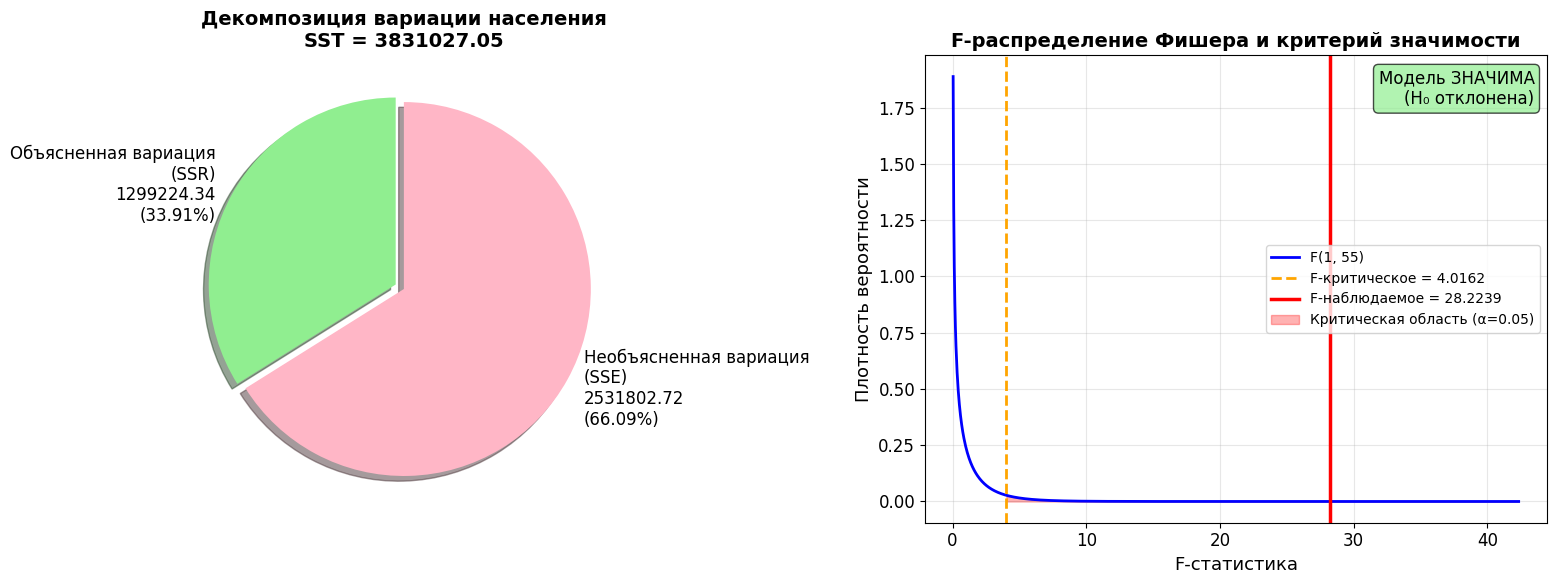


📊 Графики показывают:
  • Слева: как общая вариация населения делится на объясненную и необъясненную части
  • Справа: положение наблюдаемой F-статистики относительно критической области


In [213]:
# Визуализация статистики Фишера
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Декомпозиция вариации (пирог)
sizes = [SSR, SSE]
labels = [f'Объясненная вариация\n(SSR)\n{SSR:.2f}\n({SSR/SST*100:.2f}%)', 
          f'Необъясненная вариация\n(SSE)\n{SSE:.2f}\n({SSE/SST*100:.2f}%)']
colors = ['#90EE90', '#FFB6C6']
explode = (0.05, 0)

axes[0].pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='', shadow=True, startangle=90)
axes[0].set_title(f'Декомпозиция вариации населения\nSST = {SST:.2f}', 
                  fontsize=14, fontweight='bold')

# График 2: F-распределение
x_f = np.linspace(0, max(F_calc * 1.5, F_critical_calc * 1.5), 1000)
y_f = f_dist.pdf(x_f, df_regression, df_residual_calc)

axes[1].plot(x_f, y_f, 'b-', lw=2, label=f'F({df_regression}, {df_residual_calc})')
axes[1].axvline(F_critical_calc, color='orange', linestyle='--', lw=2, 
                label=f'F-критическое = {F_critical_calc:.4f}')
axes[1].axvline(F_calc, color='red', linestyle='-', lw=2.5, 
                label=f'F-наблюдаемое = {F_calc:.4f}')

# Закрашивание критической области
x_fill = x_f[x_f >= F_critical_calc]
y_fill = f_dist.pdf(x_fill, df_regression, df_residual_calc)
axes[1].fill_between(x_fill, y_fill, alpha=0.3, color='red', 
                      label=f'Критическая область (α={alpha})')

axes[1].set_xlabel('F-статистика', fontsize=13)
axes[1].set_ylabel('Плотность вероятности', fontsize=13)
axes[1].set_title('F-распределение Фишера и критерий значимости', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Добавление текста с результатом теста
result_text = "Модель ЗНАЧИМА\n(H₀ отклонена)" if F_calc > F_critical_calc else "Модель незначима"
axes[1].text(0.98, 0.97, result_text, transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightgreen' if F_calc > F_critical_calc else 'lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n📊 Графики показывают:")
print("  • Слева: как общая вариация населения делится на объясненную и необъясненную части")
print("  • Справа: положение наблюдаемой F-статистики относительно критической области")


### 10.4 Визуализация


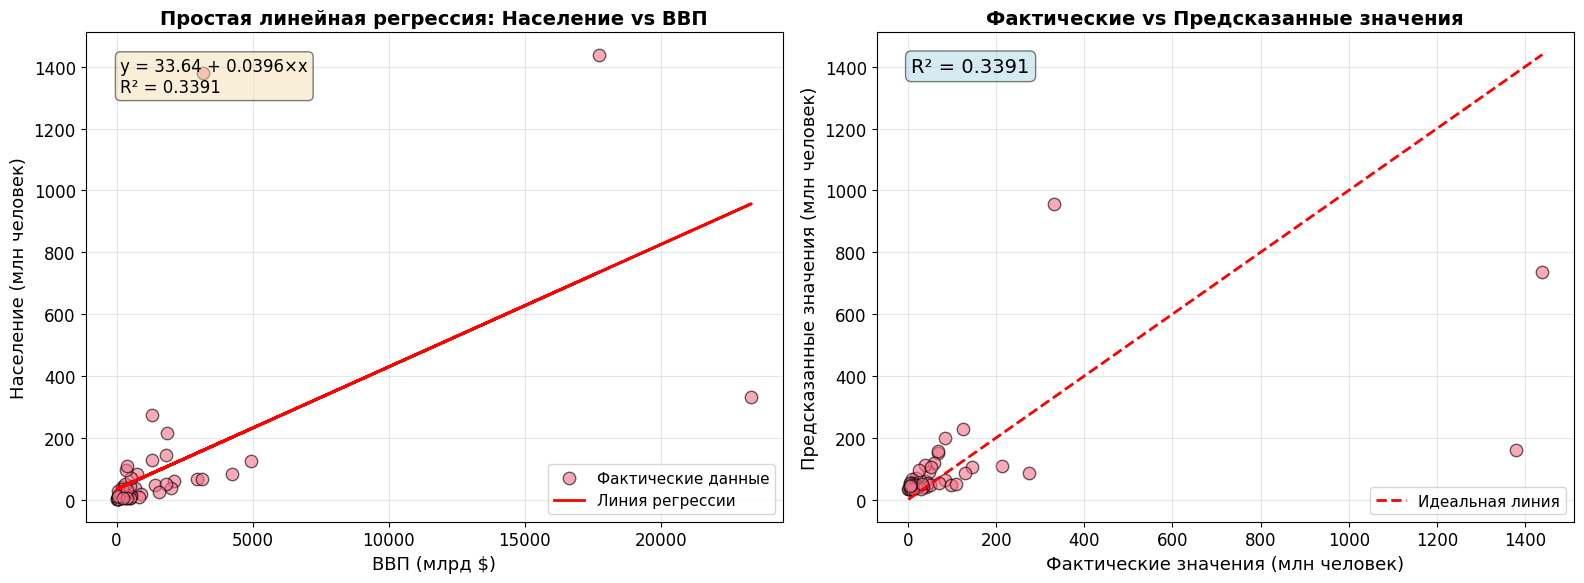

In [214]:
# График регрессии
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Линия регрессии
axes[0].scatter(X_simple, y_simple, alpha=0.6, s=80, edgecolors='k', label='Фактические данные')
axes[0].plot(X_simple, y_pred_simple, 'r-', linewidth=2, label='Линия регрессии')
axes[0].set_xlabel('ВВП (млрд $)', fontsize=13)
axes[0].set_ylabel('Население (млн человек)', fontsize=13)
axes[0].set_title('Простая линейная регрессия: Население vs ВВП', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Добавление уравнения на график
equation_text = f'y = {coef_const:.2f} + {coef_gdp:.4f}×x\nR² = {r2_simple:.4f}'
axes[0].text(0.05, 0.95, equation_text, transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# График 2: Фактические vs Предсказанные
axes[1].scatter(y_simple, y_pred_simple, alpha=0.6, s=80, edgecolors='k')
axes[1].plot([y_simple.min(), y_simple.max()], [y_simple.min(), y_simple.max()], 
             'r--', lw=2, label='Идеальная линия')
axes[1].set_xlabel('Фактические значения (млн человек)', fontsize=13)
axes[1].set_ylabel('Предсказанные значения (млн человек)', fontsize=13)
axes[1].set_title('Фактические vs Предсказанные значения', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Добавление R²
axes[1].text(0.05, 0.95, f'R² = {r2_simple:.4f}', transform=axes[1].transAxes, 
             fontsize=14, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.show()


### 10.5 Анализ остатков


АНАЛИЗ ОСТАТКОВ
Среднее значение остатков:     0.000000
Ст. отклонение остатков:       210.754814
Минимальный остаток:           -624.835731
Максимальный остаток:          1220.717812

Тест Шапиро-Уилка:  p-value = 0.000000
  ⚠ Есть отклонения от нормальности
Тест Харке-Бера:    p-value = 0.000000
  ⚠ Есть отклонения от нормальности

Тест Дарбина-Уотсона: 1.3522
  ⚠ Обнаружена автокорреляция


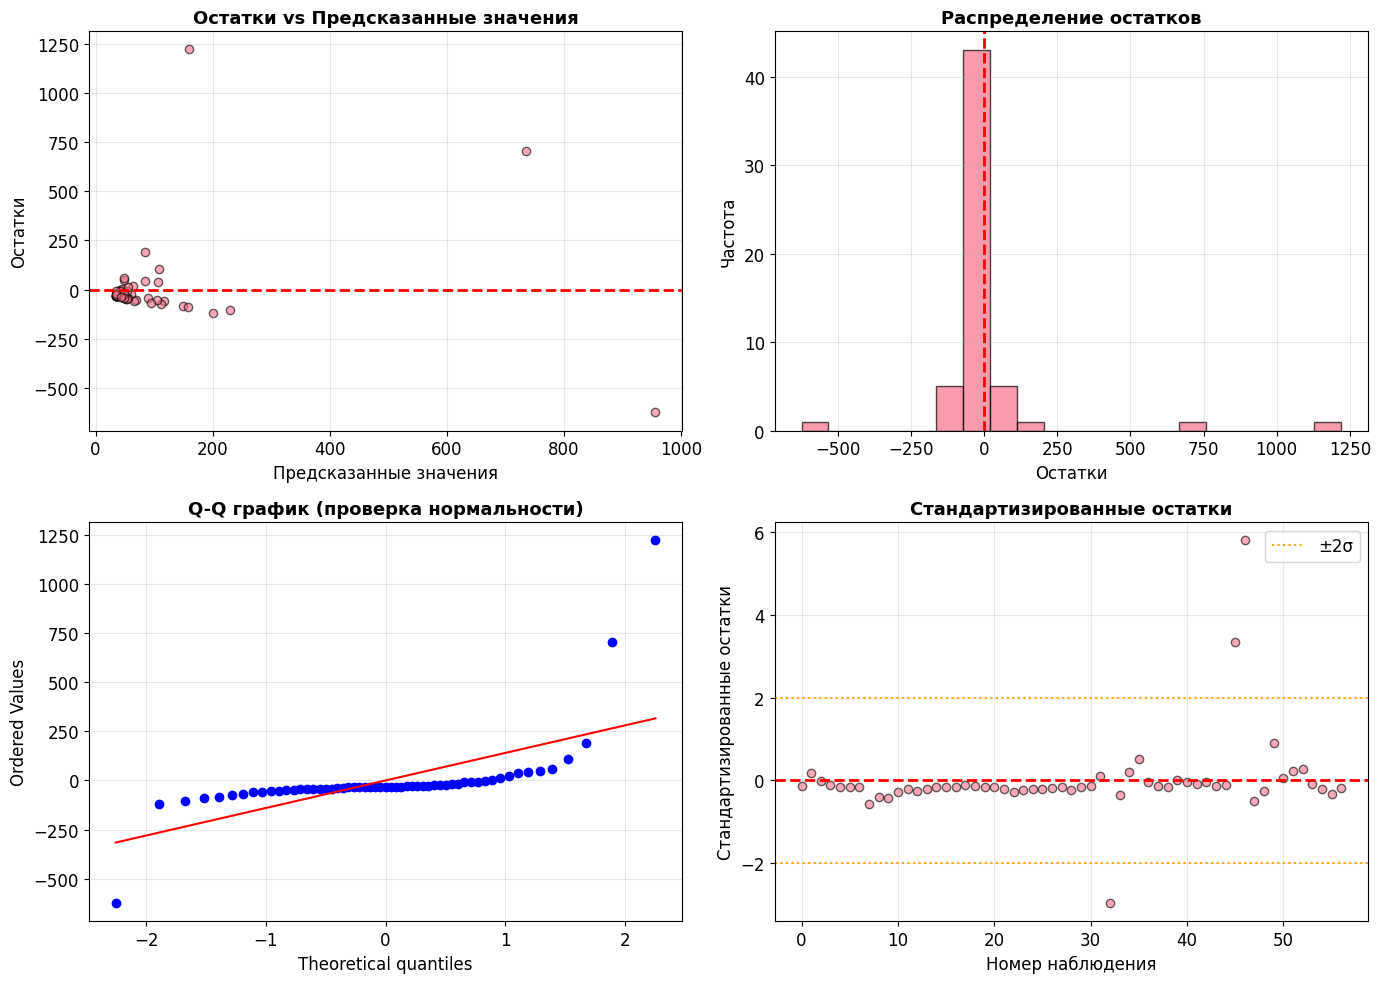

In [215]:
# Анализ остатков
residuals_simple = results_simple.resid
standardized_residuals_simple = (residuals_simple - residuals_simple.mean()) / residuals_simple.std()

# Статистика остатков
print("="*80)
print("АНАЛИЗ ОСТАТКОВ")
print("="*80)
print(f"Среднее значение остатков:     {residuals_simple.mean():.6f}")
print(f"Ст. отклонение остатков:       {residuals_simple.std():.6f}")
print(f"Минимальный остаток:           {residuals_simple.min():.6f}")
print(f"Максимальный остаток:          {residuals_simple.max():.6f}")

# Тесты на нормальность
shapiro_stat_simple, shapiro_p_simple = shapiro(residuals_simple)
jb_stat_simple, jb_p_simple, _, _ = jarque_bera(residuals_simple)

print(f"\nТест Шапиро-Уилка:  p-value = {shapiro_p_simple:.6f}")
if shapiro_p_simple > 0.05:
    print("  ✓ Остатки распределены нормально")
else:
    print("  ⚠ Есть отклонения от нормальности")

print(f"Тест Харке-Бера:    p-value = {jb_p_simple:.6f}")
if jb_p_simple > 0.05:
    print("  ✓ Остатки распределены нормально")
else:
    print("  ⚠ Есть отклонения от нормальности")

# Тест Дарбина-Уотсона
dw_stat_simple = durbin_watson(residuals_simple)
print(f"\nТест Дарбина-Уотсона: {dw_stat_simple:.4f}")
if 1.5 <= dw_stat_simple <= 2.5:
    print("  ✓ Автокорреляция отсутствует")
else:
    print("  ⚠ Обнаружена автокорреляция")

print("="*80)

# Визуализация остатков
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Остатки vs предсказанные значения
axes[0, 0].scatter(y_pred_simple, residuals_simple, alpha=0.6, edgecolors='k')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Предсказанные значения', fontsize=12)
axes[0, 0].set_ylabel('Остатки', fontsize=12)
axes[0, 0].set_title('Остатки vs Предсказанные значения', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Гистограмма остатков
axes[0, 1].hist(residuals_simple, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Остатки', fontsize=12)
axes[0, 1].set_ylabel('Частота', fontsize=12)
axes[0, 1].set_title('Распределение остатков', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot
stats.probplot(residuals_simple, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q график (проверка нормальности)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Стандартизированные остатки
axes[1, 1].scatter(range(len(standardized_residuals_simple)), standardized_residuals_simple, 
                   alpha=0.6, edgecolors='k')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].axhline(y=2, color='orange', linestyle=':', linewidth=1.5, label='±2σ')
axes[1, 1].axhline(y=-2, color='orange', linestyle=':', linewidth=1.5)
axes[1, 1].set_xlabel('Номер наблюдения', fontsize=12)
axes[1, 1].set_ylabel('Стандартизированные остатки', fontsize=12)
axes[1, 1].set_title('Стандартизированные остатки', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 10.6 Сравнение простой и множественной регрессии


In [216]:
# Сравнительная таблица
print("="*100)
print("СРАВНЕНИЕ ПРОСТОЙ И МНОЖЕСТВЕННОЙ РЕГРЕССИИ")
print("="*100)

comparison_df = pd.DataFrame({
    'Показатель': [
        'Количество факторов',
        'R²',
        'R²_adj',
        'RMSE',
        'MAE',
        'F-статистика',
        'p-value (F-test)',
        'AIC',
        'BIC',
        'Тест Шапиро-Уилка (p-value)',
        'Тест Дарбина-Уотсона'
    ],
    'Простая регрессия (только ВВП)': [
        f'{k_simple}',
        f'{r2_simple:.6f}',
        f'{r2_adj_simple:.6f}',
        f'{rmse_simple:.6f}',
        f'{mae_simple:.6f}',
        f'{f_statistic_simple:.6f}',
        f'{f_pvalue_simple:.10f}',
        f'{results_simple.aic:.6f}',
        f'{results_simple.bic:.6f}',
        f'{shapiro_p_simple:.6f}',
        f'{dw_stat_simple:.6f}'
    ],
    'Множественная регрессия (ВВП + Урбанизация)': [
        f'{k}',
        f'{r2:.6f}',
        f'{r2_adj:.6f}',
        f'{rmse:.6f}',
        f'{mae:.6f}',
        f'{f_statistic:.6f}',
        f'{f_pvalue:.10f}',
        f'{results.aic:.6f}',
        f'{results.bic:.6f}',
        f'{shapiro_p:.6f}',
        f'{dw_stat:.6f}'
    ]
})

print(comparison_df.to_string(index=False))
print("="*100)

print("\nВЫВОДЫ:")
print("-"*100)

# Сравнение R²
print(f"\n1. Качество объяснения вариации (R²):")
if r2 > r2_simple:
    improvement = (r2 - r2_simple) * 100
    print(f"   ✓ Множественная регрессия лучше на {improvement:.2f} процентных пунктов")
    print(f"   ✓ Добавление фактора 'Урбанизация' улучшило модель")
else:
    print(f"   ⚠ Простая регрессия показывает сопоставимые результаты")

# Сравнение RMSE
print(f"\n2. Точность предсказаний (RMSE):")
if rmse < rmse_simple:
    improvement_rmse = ((rmse_simple - rmse) / rmse_simple) * 100
    print(f"   ✓ Множественная регрессия точнее на {improvement_rmse:.2f}%")
else:
    print(f"   ⚠ Простая регрессия показывает сопоставимую точность")

# Информационные критерии
print(f"\n3. Информационные критерии (AIC/BIC):")
print(f"   Меньшее значение = лучшая модель")
if results.aic < results_simple.aic:
    print(f"   ✓ Множественная регрессия лучше по AIC ({results.aic:.2f} < {results_simple.aic:.2f})")
else:
    print(f"   ⚠ Простая регрессия лучше по AIC ({results_simple.aic:.2f} < {results.aic:.2f})")

if results.bic < results_simple.bic:
    print(f"   ✓ Множественная регрессия лучше по BIC ({results.bic:.2f} < {results_simple.bic:.2f})")
else:
    print(f"   ⚠ Простая регрессия лучше по BIC ({results_simple.bic:.2f} < {results.bic:.2f})")

# Общий вывод
print(f"\n4. ОБЩИЙ ВЫВОД:")
if r2 > r2_simple and rmse < rmse_simple:
    print("   ✓ Множественная регрессия превосходит простую по всем основным показателям")
    print("   ✓ Рекомендуется использовать множественную регрессию для прогнозирования")
elif r2_simple > r2 or (abs(r2 - r2_simple) < 0.05 and results_simple.bic < results.bic):
    print("   ⚠ Простая регрессия показывает сопоставимые или лучшие результаты")
    print("   ⚠ По принципу парсимонии можно использовать более простую модель")
else:
    print("   ⚠ Обе модели имеют свои преимущества и недостатки")
    print("   ⚠ Выбор зависит от конкретных целей анализа")

print("="*100)


СРАВНЕНИЕ ПРОСТОЙ И МНОЖЕСТВЕННОЙ РЕГРЕССИИ
                 Показатель Простая регрессия (только ВВП) Множественная регрессия (ВВП + Урбанизация)
        Количество факторов                              1                                           2
                         R²                       0.339132                                    0.462004
                     R²_adj                       0.327116                                    0.442078
                       RMSE                     210.754814                                  190.155819
                        MAE                      85.995110                                  104.114421
               F-статистика                      28.223897                                   23.186267
           p-value (F-test)                   0.0000020136                                0.0000000538
                        AIC                     775.738273                                  766.013190
                        BIC  

### 10.7 Итоговые выводы по простой регрессии


In [217]:
print("="*100)
print("ИТОГОВЫЕ ВЫВОДЫ ПО ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИИ")
print("="*100)

print("\n1. УРАВНЕНИЕ РЕГРЕССИИ:")
print(f"   y = {coef_const:.4f} + {coef_gdp:.4f} × ВВП")
print(f"\n   Экономическая интерпретация:")
print(f"   - Каждый миллиард долларов ВВП увеличивает население на {coef_gdp:.4f} млн человек")
print(f"   - ВВП является статистически значимым предиктором (p < 0.001)")

print(f"\n2. КАЧЕСТВО МОДЕЛИ:")
print(f"   - R² = {r2_simple:.4f} ({r2_simple*100:.2f}% объясненной вариации)")
if r2_simple >= 0.3:
    print(f"   ✓ Модель объясняет существенную часть вариации")
else:
    print(f"   ⚠ Модель объясняет небольшую часть вариации")
print(f"   - RMSE = {rmse_simple:.2f} млн человек")
print(f"   - Модель статистически значима (F-test: p < 0.001)")

print(f"\n3. ПРЕДПОСЫЛКИ МНК:")
print(f"   - Среднее остатков ≈ 0: ✓")
if shapiro_p_simple > 0.05:
    print(f"   - Нормальность остатков: ✓")
else:
    print(f"   - Нормальность остатков: ⚠ (есть выбросы)")
if 1.5 <= dw_stat_simple <= 2.5:
    print(f"   - Отсутствие автокорреляции: ✓")
else:
    print(f"   - Отсутствие автокорреляции: ⚠")

print(f"\n4. ПРИМЕНИМОСТЬ:")
if f_pvalue_simple < 0.05 and r2_simple >= 0.3:
    print("   ✓ Модель адекватна и может использоваться для:")
    print("     • Понимания связи между ВВП и населением")
    print("     • Приблизительного прогнозирования населения по ВВП")
    print("     • Сравнительного анализа стран")
else:
    print("   ⚠ Модель имеет ограничения и требует осторожности при использовании")

print(f"\n5. ОГРАНИЧЕНИЯ:")
print("   • Модель упрощает реальность (игнорирует другие факторы)")
if shapiro_p_simple < 0.05:
    print("   • Присутствуют страны-выбросы (например, Китай, Индия)")
print("   • Линейная связь может не полностью описывать зависимость")
print("   • Требуется осторожность при экстраполяции за пределы данных")

print("\n" + "="*100)
print("\nАНАЛИЗ ЗАВЕРШЕН!")
print("="*100)


ИТОГОВЫЕ ВЫВОДЫ ПО ПРОСТОЙ ЛИНЕЙНОЙ РЕГРЕССИИ

1. УРАВНЕНИЕ РЕГРЕССИИ:
   y = 33.6404 + 0.0396 × ВВП

   Экономическая интерпретация:
   - Каждый миллиард долларов ВВП увеличивает население на 0.0396 млн человек
   - ВВП является статистически значимым предиктором (p < 0.001)

2. КАЧЕСТВО МОДЕЛИ:
   - R² = 0.3391 (33.91% объясненной вариации)
   ✓ Модель объясняет существенную часть вариации
   - RMSE = 210.75 млн человек
   - Модель статистически значима (F-test: p < 0.001)

3. ПРЕДПОСЫЛКИ МНК:
   - Среднее остатков ≈ 0: ✓
   - Нормальность остатков: ⚠ (есть выбросы)
   - Отсутствие автокорреляции: ⚠

4. ПРИМЕНИМОСТЬ:
   ✓ Модель адекватна и может использоваться для:
     • Понимания связи между ВВП и населением
     • Приблизительного прогнозирования населения по ВВП
     • Сравнительного анализа стран

5. ОГРАНИЧЕНИЯ:
   • Модель упрощает реальность (игнорирует другие факторы)
   • Присутствуют страны-выбросы (например, Китай, Индия)
   • Линейная связь может не полностью описывать 